# ML
(started while reading Gerome's HOML)


TODO: start doing bits revision from here:

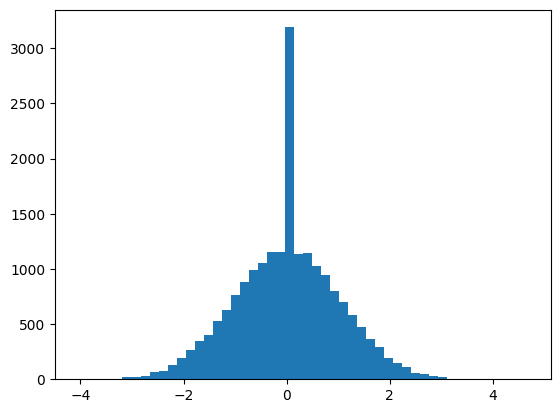

In [ ]:
"""Impute, transform, scale"""

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline

# Make data
m, n = 100_000, 1
X = np.random.randn(m).reshape(-1,1)
X -= X.min() - 1.0
X **= 3
X[np.random.permutation(m)[:int(m*0.1)]] = np.nan  #  0.1 = proportion of nans

# Train Test Split
Xtrain, Xtest = train_test_split(X, test_size=0.2)

# Impute, Transform, Scale
imputer = SimpleImputer(strategy='median')
transformer = FunctionTransformer(lambda x: x ** (1/3), inverse_func=lambda x: x**3)
scaler = StandardScaler()

# Pipeline
pl = make_pipeline(imputer, transformer, scaler)
pl.fit(Xtrain)

# Visualize
Xtest = pl.transform(Xtest)
plt.hist(Xtest, bins=50);

In [ ]:
"""Output dataframe"""

import pandas as pd
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Make sklearn output a DataFrame
sklearn.set_config(transform_output='pandas')

# Data
X = df = pd.DataFrame({'x1': [1,2,3,1,2,3,1,2,3], 'x2': [1,1,1,2,2,2,3,3,3]})
y = ytrue = pd.Series([1,2,3,4,5,6,7,8,9])

# Scale
X = StandardScaler().fit_transform(X)  # X is a DataFrame

# Witness
print(X.head())

# Model
md = LinearRegression().fit(X,y)

# Predict
ypred = md.predict(X)

# Set back to default
sklearn.set_config(transform_output='default')

In [ ]:
"""Building a big pipeline"""

import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


## Data Cleaning ###

class AColumnTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        col = 'A'
        X[col] = X[col].apply(lambda cell: int(cell))
        return X

class BColumnTransformer(BaseEstimator, TransformerMixin):
    ...

cleaning_pipeline = Pipeline([
    ('a_column_transformer', AColumnTransformer()),
    ('b_column_transformer', BColumnTransformer()),
])
#---------------------------------------------------------

### Imputing Missing Values and further preprocessing ###

numerical_pipeline = Pipeline([
    ('numerical_imputer', SimpleImputer(strategy='median')),
    ('function_transformer', FunctionTransformer(np.sqrt, validate=True)),
    ('scaler', StandardScaler()),
])

categorical_pipeline = Pipeline([
    ('categorical_imputer', SimpleImputer(strategy='most_frequent')),
    ('one_hot_encoder', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)),
])

### Parallelize the two pipelines ###

numerical_features = ['A', 'B']
categorical_features = ['C']

imputing_pipeline = ColumnTransformer([
    ('numerical_pipeline', numerical_pipeline, numerical_features),
    ('categorical_pipeline', categorical_pipeline, categorical_features),
                                      ], remainder='passthrough')
#----------------------------------------------------------------------------

### Connect the two pipelines ###

preprocessing_pipeline = Pipeline([
    ('cleaning_pipeline', cleaning_pipeline),
    ('imputing_pipeline', imputing_pipeline),
])

### Display this pipeline in a Jupyter cell ###
preprocessing_pipeline


Pipeline(steps=[('cleaning_pipeline',
                 Pipeline(steps=[('a_column_transformer', AColumnTransformer()),
                                 ('b_column_transformer',
                                  BColumnTransformer())])),
                ('imputing_pipeline',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical_pipeline',
                                                  Pipeline(steps=[('numerical_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('function_transformer',
                                                                   FunctionTransformer(func=<ufunc 'sqrt'>,
                                                                                       validate=True)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['A', 'B']),
                                                 ('categorical_pipeline',
                                                  Pipeline(steps=[('categorical_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one_hot_encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['C'])]))])

In [ ]:
"""One-Hot Encoding"""

import numpy as np, pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Data
m,n = 100, 3
X = np.random.randn(m,n).round(2)
df = pd.DataFrame(X, columns=["x1", "x2", "x3"])
df['x2'] = np.array(['f', 'm'])[(X[:,1] >= 0).astype(int)]
df['x3'] = pd.cut(X[:,2], bins=[-np.inf, -1, 1, np.inf], labels=[0,1,2], ordered=True)

# One-Hot Encoding
num_features = ['x1']
cat_features = ['x2', 'x3']
oh = OneHotEncoder(categories='auto', drop='first', sparse_output=False,
                   handle_unknown='ignore')
nd = oh.fit_transform(df[cat_features])

# for demonstration/visualization purposes:
df_out = pd.DataFrame(np.hstack([df[num_features], nd]),
                      columns=['x1'] + list(oh.get_feature_names_out()))
print(df_out.head())

# this would raise an exception if handle_unknown='error': Found unknown categories ['d']
Xnew = [['m', 2],
        ['f', 0],
        ['d', 3]]  # this row will be full of zeros
nd_new = oh.transform(Xnew)
nd_new

     x1  x2_m  x3_1  x3_2
0  0.51   1.0   1.0   0.0
1 -0.89   1.0   1.0   0.0
2  0.63   1.0   0.0   0.0
3  1.03   1.0   0.0   0.0
4 -0.71   1.0   1.0   0.0


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


array([[1., 0., 1.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [ ]:
"""Min-Max Scaler"""

import numpy as np, pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

sklearn.set_config(transform_output='pandas')

# Data
m, n = 100, 3
X = np.random.normal(loc=[-1, 0, 1.5], scale=[1,2,3], size=(m,n))
df = pd.DataFrame(X, columns=[f'x{i+1}' for i in range(n)])
df['y'] = df.sum(axis=1)

# Train Test Split
df_train, df_test = train_test_split(df, test_size=0.2)

# Isolate the targets
y_train = df_train.pop('y')
y_test = df_test.pop('y')

# Scale
scaler = MinMaxScaler(feature_range=(-1, 1), clip=False)
df_train_scaled = scaler.fit_transform(df_train)
df_test_scaled = scaler.transform(df_test)

# Set back to default
sklearn.set_config(transform_output='default')

df_test_scaled.head()

,x1,x2,x3
56,0.043290,-0.085371,0.657073
9,0.137743,-0.835270,0.062839
26,0.338603,-0.134873,0.463875
47,0.084565,-1.283132,1.038213
35,-0.554816,0.227815,0.349784


In [ ]:
"""Standard Scaler with a sparse matrix"""

import numpy as np, pandas as pd
from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler

# Data
m, n = 1000, 10
X = np.random.normal(loc=np.random.randn(n),
                     scale=np.random.randint(1, n, size=n),
                     size=(m,n))
X = np.clip(X, a_min=0, a_max=np.inf).round(2)

# Make a sparse matrix
sm = csr_matrix(X)

# Scale: standerdize without centering
scaler = StandardScaler(with_mean=False)
sm_scaled = scaler.fit_transform(sm)

In [ ]:
"""Sparse MAtrix (CSR)"""

from IPython.display import Image
url = "https://www.researchgate.net/publication/357418189/figure/fig1/AS:1106555248345089@1640834738634/The-Compressed-Sparse-Row-CSR-format-for-representing-sparse-matrices-provides-a.ppm"
Image(url=url)

In [ ]:
"""Knn Imputer"""

import numpy as np, pandas as pd
np.set_printoptions(suppress=True)


m = 10
n = 3
p = 0.25
X = np.repeat(list(range(1, m+1)), n).reshape(m,n) * np.logspace(0, n-1, num=n, base=10)
x1 = X[:,0].copy()
X.ravel()[np.random.permutation(X.size)[:int(m*n*p)]] = np.nan
X[:,0] = x1
df = pd.DataFrame(X, columns=[f"x{i+1}" for i in range(n)])
print(df,end="\n\n")


# Train Test Split
from sklearn.model_selection import train_test_split
Xtrain, Xtest = train_test_split(df, test_size=0.2)

# KNN Imputer
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=2, weights='uniform')

Xtrain_imputed = imputer.fit_transform(Xtrain)
Xtrain_imputed = Xtrain_imputed[np.argsort(Xtrain_imputed[:,0])]
print(Xtrain_imputed, end="\n\n")

Xtest_imputed = imputer.transform(Xtest)
Xtest_imputed = Xtest_imputed[np.argsort(Xtest_imputed[:,0])]
print(Xtest_imputed)

     x1    x2      x3
0   1.0  10.0   100.0
1   2.0  20.0   200.0
2   3.0  30.0   300.0
3   4.0  40.0     NaN
4   5.0   NaN   500.0
5   6.0  60.0   600.0
6   7.0  70.0   700.0
7   8.0  80.0     NaN
8   9.0  90.0   900.0
9  10.0   NaN  1000.0

[[  1.  10. 100.]
 [  2.  20. 200.]
 [  3.  30. 300.]
 [  4.  40. 400.]
 [  5.  60. 500.]
 [  7.  70. 700.]
 [  8.  80. 600.]
 [  9.  90. 900.]]

[[   6.   60.  600.]
 [  10.   60. 1000.]]


In [ ]:
"""Feature Transformation"""
# DO: log(x1/x2);      DON'T: log(x1)/log(x2)

import numpy as np, pandas as pd
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.pipeline import make_pipeline, make_union
import matplotlib.pyplot as plt


def get_peaks(a, n_peaks, return_bins=False):
    """
    Finds n_peaks in distribution 'a'
    sorted by the peaks height
    """
    for n_bins in range(int(len(a)**(1/2)), 5, -1):
        y, x = np.histogram(a, bins=n_bins)
        d = np.sign(y[1:] - y[:-1])
        d2 = d[1:] - d[:-1]
        mask = d2 == -2
        if sum(mask) <= n_peaks:
            break

    # Mask to get the peaks
    offset = (len(x)-len(mask)) // 2
    mask = [False]*offset + list(mask) + [False]*(len(x)-len(mask)-offset)
    try:
        idx = np.nonzero(mask)[0]
        peaks = (x[idx] + x[idx+1]) / 2
    except:
        peaks = x[mask]

    # Sort the peaks according to height
    heights = y[mask[:len(y)]]
    idx = np.argsort(heights)
    peaks = np.take(peaks, idx)[::-1]

    # Return a list or a tuple of lists according to 'return_bins'
    return (peaks, n_bins) if return_bins else peaks


# Make data
np.random.seed(42)
m, n = 1000, 2
X = np.random.normal(size=(m,n))
X[:m//3, 1] = np.random.normal(loc=1.5, scale=0.3, size=m//3)
X -= X.min(axis=0) - 1
X[:, 0] = np.exp(X[:, 0] / 2)
X[:, 1] = np.exp(X[:, 1] / 1.7)
df = pd.DataFrame(X, columns=["milage", "age"]) # ship's milage / age


# Feature transformation and engineering (for EDA only)
df[["log_milage", "log_age"]] = np.log(df[["milage", "age"]])
df["log_milage_per_year"] = np.log(df['milage'] / df['age'])

peaks = get_peaks(df['age'], n_peaks=2)   #[ 6.9, 23.9]
gamma = 0.02   # determined manually / visually
df["similarity_to_peak_at_7"] = rbf_kernel(df[['age']], [[peaks[0]]], gamma=gamma)
df["similarity_to_peak_at_24"] = rbf_kernel(df[['age']], [[peaks[1]]], gamma=gamma)


# Visualize the peaks and Gaussian RBF's
axes = df.hist(bins=19, figsize=(10,7))
axes[0,1].vlines(peaks, ymin=0, ymax=160, color='k', linewidth=0.5)
axes[0,1].scatter(df['age'], df["similarity_to_peak_at_7"] * 160, color='red', s=0.5, alpha=0.6)
axes[0,1].scatter(df['age'], df["similarity_to_peak_at_24"] * 120, color='purple', s=0.5, alpha=0.6)


# Define Funtion Transformers (for pipeline)
log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
ratio_transformer = FunctionTransformer(lambda X: np.log(X[:, [0]] / X[:, [1]]))
rbf_transformer = FunctionTransformer(lambda X, Y, gamma: rbf_kernel(X[:, [1]], Y=Y, gamma=gamma),
                  kw_args=dict(Y=peaks.reshape(-1,1), gamma=gamma))
standard_scaler = FunctionTransformer(lambda X: np.c_[(X[:, :3] - X[:, :3].mean(0)) / X[:, :3].std(0), X[:, 3:]])


# Make a preprocessing pipeline
fu = make_union(log_transformer, ratio_transformer, rbf_transformer)
pl = make_pipeline(fu, standard_scaler)

# Pretend this is our train set
X_train = df[['milage', 'age']].values

# Put the data set trhough the transformation pipline
X_transformed = pl.fit_transform(X_train)

# Visualize
pd.DataFrame(X_transformed, columns=["log_milage", "log_age", "log_milage_per_year", "similarity_to_peak_at_7", "similarity_to_peak_at_24"]).hist(bins=30, figsize=(10,7));


In [ ]:
### CUSTOM TRANSFORMER AND PY-TESTS FOR IT ###

"""
The name of this file is assumed to 'test_this_file.py' (for pytest's sake')

TO RUN THE TESTS (SEE BELOW) DO:
$ cd thisfolder; pytest
or:
$ pytest thisfolder/test_this_file.py
"""

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted
import numpy as np, pandas as pd


class MyStandardScaler(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):  # no *args, **kwargs !
        self.with_mean = with_mean

    def fit(self, X, y=None):
        self.feature_names_in_ = list(X.columns) if isinstance(X, pd.DataFrame) else None
        X = check_array(X)
        self.mean_ = X.mean(axis=0)
        self.std_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]
        return self

    def get_feature_names_out(self):
        return self.feature_names_in_

    def _validate(self, X):
        check_is_fitted(self)

        if isinstance(X, pd.DataFrame):
            if list(X.columns) != self.feature_names_in_:
                raise ValueError("Column names must match")
            X = pd.DataFrame(check_array(X), columns=X.columns)
        else:
            X = check_array(X)

        if self.n_features_in_ != X.shape[1]:
            raise ValueError("n_features do not match")
        return X

    def transform(self, X):
        X = self._validate(X)

        if self.with_mean:
            X = X - self.mean_

        return X / self.std_

    def inverse_transform(self, X):
        X = self._validate(X)
        X = X * self.std_
        return X + self.mean_ if self.with_mean else X



##### PY-TESTS #####
# the name of this file is 'test_this_file.py'

import pytest
import numpy as np, pandas as pd


# Make data
m, n = 10, 5
ls = np.random.binomial(n=10, p=0.5, size=(m,n)).tolist()
X = nd = np.array(ls)

# FIXTURES
@pytest.fixture
def X_fixture():
    return nd

@pytest.fixture
def df_fixture():
    return pd.DataFrame(X,  columns=[f"x{i}" for i in range(n)])

@pytest.fixture
def scaler_fixture():
    return MyStandardScaler()


# TESTS
def test_has_attribute(scaler_fixture):
    assert hasattr(scaler_fixture, 'fit_transform')

def test_accepts_lists():
    tr = MyStandardScaler().fit(ls)  # this must not raise an error
    tr.transform(ls)                 # and this must not raise an error either

@pytest.mark.filterwarnings("ignore")
def test_outputs_dataframe(scaler_fixture, df_fixture):
    scaler_fixture.fit(df_fixture)
    output = scaler_fixture.transform(df_fixture)
    assert isinstance(output, pd.DataFrame), "My Test: The output must be a df"

@pytest.mark.filterwarnings("ignore")
def test_identical_feature_names(scaler_fixture, df_fixture):
    tr = scaler_fixture.fit(df_fixture)
    df_transformed = tr.transform(df_fixture)
    df_inverse = tr.inverse_transform(df_transformed)
    assert list(tr.feature_names_in_) == list(df_transformed.columns), "TODO"
    assert list(tr.feature_names_in_) == list(df_inverse.columns), "TODO"

@pytest.mark.filterwarnings("ignore")
def test_get_feature_names_out(scaler_fixture, df_fixture):
    scaler_fixture.fit(df_fixture)
    assert list(df_fixture.columns) == list(scaler_fixture.get_feature_names_out())

def test_inverse_transform(scaler_fixture, X_fixture):
    tr = scaler_fixture
    X_inv = tr.inverse_transform(tr.fit_transform(X_fixture))
    assert np.allclose(X_inv, X_fixture), "The input X must be np.allclose to the output of the 'inverse_transform' method"

def test_with_mean(scaler_fixture):
    tr = scaler_fixture
    tr.fit(X)
    X_transformed = tr.transform(X)
    assert np.allclose(X_transformed.mean(0), 0)

def test_without_mean(X_fixture):
    means = (X_fixture / X_fixture.std(0)).mean(0)
    tr = MyStandardScaler(with_mean=False)
    tr.fit(X_fixture)
    X_transformed = tr.transform(X_fixture)
    assert np.allclose(means, X_transformed.mean(axis=0))

def test_n_features_match(scaler_fixture, X_fixture):
    tr = scaler_fixture.fit(X_fixture)
    bad_input = np.c_[X_fixture, X_fixture[:, [0]]]
    with pytest.raises(ValueError):
        tr.transform(bad_input)


In [ ]:
"""COLUMN TRANSFROMER (drop, passthrough, remainder)"""

import numpy as np, pandas as pd
from string import ascii_uppercase

# make data
m, n = 100, 10
df = pd.DataFrame(np.random.normal(size=(m,n)), columns=[f"x{i+1}" for i in range(n)]).round(2)
df.iloc[:, 3:5] = (pd.DataFrame(np.random.binomial(n=25, p=[0.01, 0.99], size=(m,2)))
                     .applymap(lambda x: ascii_uppercase[x]))  #'applymap' is depricated, use 'map'
df.iloc[:, 6:9] = np.nan


# DEMO ON COLUMN-TRANSFROMER
from sklearn.pipeline import Pipeline, make_pipeline, make_union
from sklearn.compose import (ColumnTransformer,
                             make_column_transformer,
                             make_column_selector)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy='median')),
        ("scaler", StandardScaler())
    ])

cat_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'),
                             OneHotEncoder(drop=None,
                                           handle_unknown='ignore',
                                           sparse_output=False))

# Make a Column Transformer out of the two pipelines
ct = make_column_transformer(
        (num_pipeline, make_column_selector(dtype_include=np.number)),
        (cat_pipeline, make_column_selector(dtype_include=object))
    )

# ...or like this:
ct = ColumnTransformer([
        ("pipeline_1", num_pipeline, [0, 1, 2]),   # use indeces
        ("pipeline_2", cat_pipeline, make_column_selector(dtype_include=object)),
        ("pass", 'passthrough', ['x6']),           # or column names
        ("drop", 'drop', slice(6, 9, None))
    ], remainder='passthrough')


X_tr = ct.fit_transform(df)
df_tr = pd.DataFrame(X_tr, columns=ct.get_feature_names_out())

print(df_tr.columns)
ct

Index(['pipeline_1__x1', 'pipeline_1__x2', 'pipeline_1__x3',
       'pipeline_2__x4_A', 'pipeline_2__x4_B', 'pipeline_2__x4_C',
       'pipeline_2__x5_X', 'pipeline_2__x5_Y', 'pipeline_2__x5_Z', 'pass__x6',
       'remainder__x10'],
      dtype='object')


ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline_1',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 [0, 1, 2]),
                                ('pipeline_2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x78e76c082860>),
                                ('pass', 'passthrough', ['x6']),
                                ('drop', 'drop', slice(6, 9, None))])

In [ ]:
"""COLUMN TRANSFORMER"""

import numpy as np, pandas as pd
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline, make_union
from sklearn.base import BaseEstimator, TransformerMixin
import warnings
warnings.filterwarnings('ignore')


def make_ratio_pipline():
    return make_pipeline(
        SimpleImputer(strategy='median'),
        FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]],
                            feature_names_out=lambda self, feature_names_in: ["ratio"]),
        StandardScaler())


class CustomTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, hyperparameter=None):
        self.hyperparameter = hyperparameter
    def fit(self, X, y=None):
        self.n_features_ = X.shape[1]
        return self
    def transform(self, X):
        return np.c_[X**2, X**3]
    def get_feature_names_out(self, feature_names_in=None):
        return [f"custom_transformer_{i+1}" for i in range(self.n_features_ * 2)]


custom_transformer_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy='mean')),
        ("transformer", CustomTransformer()),
        ("scaler", StandardScaler())
    ])

log_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    FunctionTransformer(np.log, feature_names_out='one-to-one'),
    StandardScaler()
)

cat_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

num_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

# Construct a Column Transformer
processing = ColumnTransformer([
    ("x1_per_x2", make_ratio_pipline(), ['x1', 'x2']),
    ("x1_per_x3", make_ratio_pipline(), ['x1', 'x3']), # use column names,
    ("custom", custom_transformer_pipeline, [0,1,2]),  # indeces
    ("log", log_pipeline, slice(0, 3)),                # or slices
    ("cat", cat_pipeline, make_column_selector(dtype_include=object))
],
    remainder=num_pipeline)

# Make data
def make_data():
    rs = np.random.RandomState(100)
    m, n = 100, 6
    X = rs.binomial(n=25, p=rs.random(size=n), size=(m,n))
    df = pd.DataFrame(X, columns=[f"x{i+1}" for i in range(n)])
    df.iloc[:, 3:5] = df.iloc[:, 3:5].applymap(lambda x: chr(65+x))  # appylmap is depricated
    idx = rs.permutation(m*n)[:int(0.1 * n * m)]
    for ix in idx:
        if ix % n: # skips the last column
            df.iloc[ix//n, (ix%n)-1] = np.nan  # do not use pd.NA !!!
    return df

# Demo
df = make_data()
X_processed = processing.fit_transform(df)
df_processed = pd.DataFrame(X_processed, columns=processing.get_feature_names_out())
df_processed.columns

Index(['x1_per_x2__ratio', 'x1_per_x3__ratio', 'custom__custom_transformer_1',
       'custom__custom_transformer_2', 'custom__custom_transformer_3',
       'custom__custom_transformer_4', 'custom__custom_transformer_5',
       'custom__custom_transformer_6', 'log__x1', 'log__x2', 'log__x3',
       'cat__x4_R', 'cat__x4_S', 'cat__x4_T', 'cat__x4_U', 'cat__x4_V',
       'cat__x4_W', 'cat__x4_X', 'cat__x4_Y', 'cat__x4_Z', 'cat__x5_A',
       'cat__x5_B', 'remainder__x6'],
      dtype='object')

In [ ]:
"""PIPELINE WITH CACHING"""

from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
import random, numpy as np
np.set_printoptions(suppress=True)


def make_data():
    seed = 42
    random.seed(seed)
    rs = np.random.RandomState(seed=seed)

    m, n = 10, 2
    min_power, max_power = 2, 5
    n_poly_features = n * max_power

    X = rs.normal(loc=2, scale=1.0, size=(m,n)).clip(0.1, np.inf)

    powers = [tuple(int(e) for e in str(x).zfill(n)) for x in range(min_power, max_power * 10**(n-1) + 1)]
    powers = [t for t in powers if min_power <= sum(t) <= max_power]
    random.shuffle(powers)
    powers = powers[:n_poly_features]

    poly_features = np.vstack([np.multiply.reduce(X ** p, axis=1) for p in powers]).T
    weights = rs.normal(loc=0, scale=10, size=n_poly_features)
    y = (poly_features * weights).sum(axis=1)
    y = (y - y.min()).round(4)  # simulate adding a bias and errors
    return X,y

# Make data
X,y = make_data()
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2)

#########################################################################

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, LeaveOneOut


pipeline = Pipeline([
        ("poly", PolynomialFeatures()),
        ("scaler", StandardScaler()),
        ("lasso", Lasso())
    ], memory='cache')

param_grid = [
        {'poly__degree': [2, 3], 'lasso__alpha': [0.01, 0.1]},
        {'poly__degree': [4, 5, 6], 'lasso__alpha': [0.1, 1.0, 10]},
    ]
gs = GridSearchCV(estimator=pipeline, param_grid=param_grid,
                  scoring='neg_root_mean_squared_error',
                  cv=LeaveOneOut(),
                  refit=True,
                  verbose=1)
gs.fit(Xtrain, ytrain)

# Demo
ypred = gs.best_estimator_.predict(Xtest)
print(f"ytrue: {ytest.round(2)}\nypred: {ypred.round(2)}\nerror: {-round(gs.best_score_,2)}")
print(f"best parameters: {gs.best_params_}")


Fitting 8 folds for each of 13 candidates, totalling 104 fits
ytrue: [4464.03 4650.49]
ypred: [4476.94 4682.73]
error: 90.05
best parameters: {'lasso__alpha': 1.0, 'poly__degree': 6}


model1: errors = [1.25 1.32 0.98] 	 R² = [0.42 0.4  0.59]
model2: errors = [0.72 0.65 0.54] 	 R² = [0.81 0.86 0.88]
model3: errors = [0.62 0.62 0.46] 	 R² = [0.86 0.87 0.91]


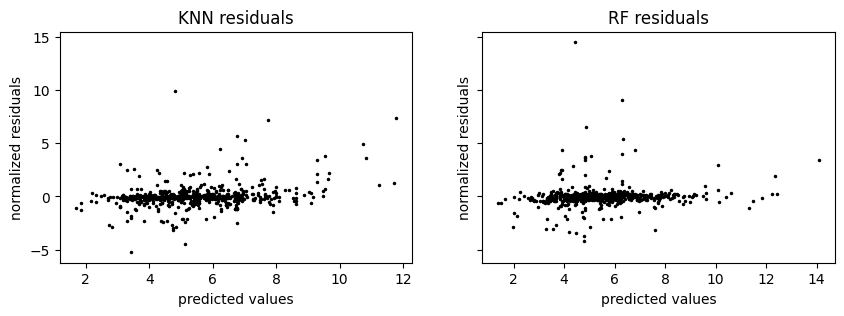

Ensemble on test-set: R² = 0.93 	 RMSE = 0.41


array([0.51245247, 0.16958982, 0.31795771])

In [ ]:
### ENSEMBLE MODEL FOR REGRESSION ###

"""
ENSEMBLE MODEL FOR REGRESSION

Regression Ensebmle model
- make a preprocessing pipeline (impute, transform, scale)
- train test split
- select 2 promising estimators out of 3 (lin, random_forest, knn)
- tune hypeporameters with rand-grid-search
- adjust model weights according to the respective R-squareds (?)
- unite into a Voting Regressor
- test on  the test set
"""

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import warnings
from scipy.stats import randint
from sklearn.preprocessing import (OrdinalEncoder,
                                   OneHotEncoder,
                                   FunctionTransformer,
                                   StandardScaler)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.base import clone
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')


def make_data():
    m, n = 1000, 2
    p = 0.05  # proportion of nans
    seed = 42
    rs = np.random.RandomState(seed)

    X = rs.normal(scale=1.0, size=(m,n))
    X_poly = np.c_[X, X ** 2 * [1, -1]]

    weights = rs.normal(size=4)
    weights[2:] = np.abs(weights[2:])  # for saddle

    y = (X_poly * weights).sum(axis=1)

    # add categorical variable
    cat = rs.binomial(n=2, p=0.5, size=m)
    y += cat * y.std()
    y = (y - y.min() + 1.0)

    # transform X
    X = np.exp(X - X.min(axis=0) + 1.0)

    # make df
    df = pd.DataFrame(np.c_[X, cat, y], columns=["x1", "x2", "x3", "y"])
    df['x3'] = pd.Categorical(df['x3'].astype(np.uint8), ordered=True)
    df.x3 = df.x3.cat.rename_categories(["S", "M", "L"])

    # nans
    idx = rs.permutation(df.size)[:int(p * df.size)]
    for ix in idx:
        df.iloc[ix // df.shape[1], ix % df.shape[1]] = np.nan
    return df


# get data
df = make_data()

# drop rows if nan in the target
df.dropna(subset=['y'], inplace=True)

# isolate the target
X, y = df.iloc[:, :-1], df['y']

# Train Test Split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression Pipeline
pl_lin = make_pipeline(ColumnTransformer([
            ("num",
             make_pipeline(
                     SimpleImputer(strategy='median'),
                     FunctionTransformer(np.log, inverse_func=np.exp),
                     StandardScaler()
                 ),
             make_column_selector(dtype_include=np.number)),

            ("cat",
             make_pipeline(
                     SimpleImputer(strategy='most_frequent'),
                     OneHotEncoder(drop='first', handle_unknown='ignore')
                 ),
             make_column_selector(dtype_include=[object, 'category']))
                                        ]),
            LinearRegression()
    )

# KNN Regression Pipeline
pl_knn = clone(pl_lin)
pl_knn.steps[0][1].transformers[1][1].steps[1][1].drop = None
pl_knn.steps[-1] = ('knn', KNeighborsRegressor())

# Random Forest Regressor Pipeline
pl_rf = make_pipeline(ColumnTransformer([
            ("num", SimpleImputer(strategy='median'), make_column_selector(dtype_include=np.number)),
            ("cat",
             make_pipeline(
                     SimpleImputer(strategy='most_frequent'),
                     OrdinalEncoder(categories=[['S', 'M', 'L']], handle_unknown='error')
                 ),
             make_column_selector(dtype_include=[object, 'category']))
                                        ]),
            RandomForestRegressor()
    )

# Select two promising models
for i, model in enumerate([pl_lin, pl_knn, pl_rf]):
    errors = -cross_val_score(estimator=model, X=Xtrain, y=ytrain,
                             cv=3, scoring='neg_root_mean_squared_error')
    rsq = cross_val_score(estimator=model, X=Xtrain, y=ytrain,
                          cv=3, scoring='r2')
    print(f"model{i+1}: errors = {errors.round(2)} \t R² = {rsq.round(2)}")

# based on the results above we select KNN and RandomForest
models = [pl_knn, pl_rf]

# Random HP Search
hp_search_knn = GridSearchCV(pl_knn,
       {
            'knn__n_neighbors': [1,3,5],
            'knn__weights': ['uniform', 'distance'],
        },
        cv=3, scoring='neg_root_mean_squared_error')
hp_search_knn.fit(X,y)
md_knn = hp_search_knn.best_estimator_

hp_search_rf = RandomizedSearchCV(pl_rf,
        {
           'randomforestregressor__criterion': ['squared_error', 'absolute_error'],
           'randomforestregressor__max_depth': randint(10, 100),
        },
            n_iter=10, cv=3, scoring='neg_root_mean_squared_error')
hp_search_rf.fit(X,y)
md_rf = hp_search_rf.best_estimator_


# Error Analysis
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(10,3))

ytrue = ytrain
ypred = md_knn.predict(Xtrain)
residuals = ytrue - ypred
residuals = (residuals - residuals.mean()) / residuals.std()
ax1.plot(ypred, residuals, 'k.', markersize=3)
ax1.set_title("KNN Residual Plot")
ax1.set_xlabel("predicted values")
ax1.set_ylabel("normalized residuals")

ypred = md_rf.predict(Xtrain)
residuals = ytrue - ypred
residuals = (residuals - residuals.mean()) / residuals.std()
ax2.plot(ypred, residuals, 'k.', markersize=3)
ax2.set_title("RF Residual Plot")
ax2.set_xlabel("predicted values")
ax2.set_ylabel(None)
plt.show()


# Measure R² for model weights
rsq_knn = cross_val_score(estimator=md_knn, X=Xtrain, y=ytrain,
                      cv=3, scoring='r2').mean()

rsq_rf = cross_val_score(estimator=md_rf, X=Xtrain, y=ytrain,
                      cv=3, scoring='r2').mean()
model_weights = np.array([rsq_knn, rsq_rf]) / np.array([rsq_knn, rsq_rf]).sum()


# Make a Voting Regressor ensemble
ensebmle = VotingRegressor(estimators=[("knn", md_knn), ("rf", md_rf)],
                           weights=model_weights)

# Estimate the generalization error
ensebmle.fit(Xtrain, ytrain)
ypred = ensebmle.predict(Xtest)

rsq = ensebmle.score(Xtest, ytest)  # 93%
rmse = mean_squared_error(ytest, ypred) ** 0.5
print(f"Ensemble on test-set: R² = {round(rsq,2)} \t RMSE = {round(rmse,2)}")

# Dissect the RF
md_rf['randomforestregressor'].feature_importances_

In [ ]:
# FAST API

"""
main.py
$ pip install "fastapi[all]"
$ uvicorn main:app --reload
http://127.0.0.1:8000/redoc

POST requests in the bash console:

curl \
  --header "Content-Type: application/json" \
  --request POST \
  --data '{"x1": "1.25", "x2": "1"}' \
  http://localhost:8000/predict

or like this:

curl -X 'POST' \
  'http://127.0.0.1:8000/predict' \
  -H 'accept: aplication/json' \
  -H 'Content-Type: application/json' \
  -d '{
    "x1": 1.75,
    "x2": 0,
    "x3": "small"
    }'

FastAPI tutorial:
https://fastapi.tiangolo.com/tutorial/
"""

import uvicorn  # not needed if  $ uvicorn main:app
from fastapi import FastAPI
from fastapi.responses import HTMLResponse
from pydantic import BaseModel
from sklearn.linear_model import LinearRegression
import joblib


# Load your model
joblib.dump(LinearRegression().fit([[1.0, 0],[2.0, 1],[3.0, 1]], [0.1, 2.5, 3.0]), "model.pkl")
model = joblib.load("model.pkl")


app = FastAPI()


class Data(BaseModel):
    x1: float
    x2: int
    x3: str | None = None


@app.post("/predict")
async def predict(data: Data):
    d = data.dict()
    ypred, = model.predict([[d['x1'], d['x2']]])
    return {'prediction': ypred}


@app.get("/predict", response_class=HTMLResponse)
async def predict(x1: float, x2: float, x3: str = None):
    """http://127.0.0.1:8000/predict?x1=-7.25&x2=1"""
    ypred, = model.predict([[x1, x2]])
    return HTMLResponse(f"Our prediction: {ypred}")


@app.get("/")
async def root():
    return HTMLResponse("Hello World")


@app.get("/items/{item_id}")
def get_item(item_id: int):
    return {'item_id': item_id}


@app.get("/users/{user_id}/items/{item_id}")
async def get_user_item(user_id: int,
                         item_id: str,
                         q: str | None = None):
    """http://127.0.0.1:8000/users/123/items/bookshelf?q=title:%22The%20Book%22%20AND%20author:%22M.Wright%22"""
    return {"user_id": user_id, "item_id": item_id, "q": q}


if __name__ == '__main__':
    uvicorn.run(app, host='127.0.0.1', port=8000)
# or bash: $ uvicorn main:app --reload


In [ ]:
# CONFIDENCE INTERVAL FOR RMSE
from math import sqrt
from statistics import mean
import numpy as np
from scipy import stats


# given
ytest = [10.5, 12.1, 14.0, 11.0, 7.8, 8.1, 9.2]
ypred = [10.6, 12.0, 14.1, 11.1, 7.7, 8.0, 9.1]

# erros
e = np.array(ytest) - ypred

# squared errors
es = e ** 2

# select alpha
α = 0.95

# calculate q
q = (1 + α) / 2

# compute t (not z - because the test set is too small)
n = len(e)
t = stats.t.ppf(q, df=n-1) #ppf = inverse cdf
z = stats.norm.ppf(q)      # z-score (if n is large enough)

# calculate SEM
sd = es.std(ddof=1)
sem = sd / sqrt(n)

# calculate the margin (squared)
M = t * sem   # bzw z*sem

# calculate the CI
x = sum(es) / n  # average squared error
CI = [sqrt(x-M), sqrt(x+M)]

# with scipy
mean = mean(es)
sem = stats.sem(es)
CI = np.sqrt(stats.t.interval(confidence=α, df=n-1, loc=mean, scale=sem))
print(f"The {α*100:.0f}% confidence interval for the RMSE = {CI}")

confidence interval = [0.09999999999999963, 0.09999999999999964]


In [ ]:
# TEMPLATE CLASSIFIER
from sklearn.base import ClassifierMixin, BaseEstimator
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import euclidean_distances


class TemplateClassifier(ClassifierMixin, BaseEstimator):
    """Template Classifier"""
    def __init__(self, *, threshold=0.5):
        self.threshold = threshold

    def fit(self, X, y=None):
        X, y = check_X_y(X, y)  # Check that X and y have correct shape
        self.classes_ = unique_labels(y)
        self.X_, self.y_ = X,y
        self.is_fitted = True
        return self

    def predict_proba(self, X):
        check_is_fitted(self)
        X = check_array(X)
        return ...

    def predict(self, X):
        idx = np.argmin(euclidean_distances(X, self.X_), axis=1)
        return self.y_[idx]

In [ ]:
# POISSON REGRESSION
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import train_test_split
import numpy as np, pandas as pd
import warnings
np.set_printoptions(suppress=True)
warnings.filterwarnings('ignore')


# Make data
def make_data():
    m, n = 24*60, 3
    x1 = np.repeat(np.linspace(0, 1, num=m), 7)
    x2 = np.random.random(size=len(x1))
    x3 = np.random.choice([0,1], p=(0.9, 0.1), size=len(x1))
    x0 = np.ones(shape=len(x1))
    X = np.c_[x0, x1, x2, x3]

    ww = (np.abs(np.random.normal(loc=0, scale=1, size=n))) * [1, -1, 1]
    ww = np.array([3, *ww])

    y = np.multiply.reduce(np.exp(X * ww), axis=1).round().astype(int)
    df = pd.DataFrame(np.c_[X[:,1:], y], columns=["time", "price", "event", "count"])
    return df, ww

# Get data
df, weights = make_data()
X, y = df.iloc[:, :-1], df.iloc[:, -1]

# Split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2)

# Model
md = PoissonRegressor(alpha=0.0, fit_intercept=True)
md.fit(Xtrain, ytrain)

# Weights
print("ground truth weights:", list(weights.round(3)))
print("learned weights:", list(np.array([md.intercept_, *md.coef_]).round(3)))

# Estimate the generalization error
rsq = md.score(Xtest, ytest)
print("R² on test-set:", rsq.round(4))

ground truth weights: [3.0, 0.953, -1.674, 0.264]
learned weights: [3.001, 0.952, -1.676, 0.264]
R² on test-set: 0.9987


In [ ]:
# POLYNOMIAL REGRESSION - THE CORRECT WAY
"""
standedize
poly (poly-expansion will often cause multicoliniarity)
ridge / elastic (but not lasso, because it doesn't handle multicoliniarity)

Ridge handles multicoliniarity
Lasso does variable selection
ElasticNet does both
"""

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.pipeline import Pipeline


steps = [('scaler', StandardScaler()),
         ('poly', PolynomialFeatures(degree=3)),
         ('elastic', ElasticNet(alpha=1.0, l1_ratio=0.5))]
pipe = Pipeline(steps)

In [ ]:
# LightGBM CLASSIFIER

import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import fbeta_score
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


def make_data(m=100, n=5, return_dataframe=False, random_seed=None):
    rs = np.random.RandomState(random_seed)
    X = rs.binomial(n=range(n, 0, -1), p=0.5, size=(m,n))
    y = X.sum(axis=1) % 2
    if return_dataframe:
        X,y = pd.DataFrame(X, columns=[f"x{i+1}" for i in range(n)]), pd.Series(y)
    return X,y


# get data
X, y = make_data()
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


# LightGBM
import lightgbm as lgb

train_data = lgb.Dataset(Xtrain, label=ytrain, categorical_feature=[3, 4])

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'average_precision',  # ???
    'learning_rate': 0.05,
    'verbose': 0}

num_round = 100
gb = lgb.train(params, train_data, num_round)
ypred = gb.predict(Xtest) >= 0.5


# LGBMClassifier
from lightgbm import LGBMClassifier

# get data
X, y = make_data(return_dataframe=True)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)



# Integrate an LGBMClassifier into sklearn's pipeline
pl = make_pipeline(
    ColumnTransformer([
        ("num", 'passthrough', make_column_selector(dtype_include=np.number)),
        ("cat", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), make_column_selector(dtype_include=['category', object]))
                ],
        remainder='passthrough'),
    LGBMClassifier(objective='binary'))

params = {f'{pl.steps[-1][0]}__feature_name': list(Xtrain.columns),
          f'{pl.steps[-1][0]}__categorical_feature': ['x4', 'x5'],
          f'{pl.steps[-1][0]}__eval_metric': 'auc'}

pl.fit(Xtrain, ytrain, **params)
ypred = pl.predict(Xtest)


# Plot feature importances
lgb.plot_importance(pl.steps[-1][1], importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance");


In [ ]:
# THRESHOLD OPTIMIZATION

import numpy as np
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, fbeta_score
from functools import partial


# Get data
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit and predict probabilities
clf = LogisticRegression().fit(X_train, y_train)
probs = clf.predict_proba(X_val)[:, 1]  # Probabilities of class 1

# Try all the thresholds
f2 = partial(fbeta_score, beta=2)
thresholds = np.linspace(0, 1, 100)
f2_scores = [f2(y_val, (probs > thresh).astype(int)) for thresh in thresholds]

best_threshold = thresholds[np.argmax(f2_scores)]
best_f2_score = max(f2_scores)
print("best threshold:", best_threshold)
print("best f2-Score:", best_f2_score)

best threshold: 0.16161616161616163
best f2-Score: 0.8985765124555161


In [ ]:
# SOFT CLASSIFYING ENSEMBLE WITH UPSAMPLING AND OPTIMIZED THRESHOLD
"""
UPSAMPLE OR NOT TO UPSAMPLE THE RARE CLASS:
Support Vector:      yes
Logistic Regression: yes
Tree-based:          only if extreme imbalanced
Naive Bayes:         not nececarry, only if extreme imbalanced


GOAL: F2
- make train val test sets
- make a pipeline with upsamping, etc (for NB not cesessary to upsampel (but will not hurt))
- cross valscore to select top 3 models based on f2
- measure the pairwise distance of the FN sets (the more the better)
- grid search HP each classifier
- unite into one soft voting classifier
- oprimize the threshold of the single voting classsifier for the best F2 on the val set
"""

from itertools import combinations
import numpy as np, pandas as pd
from scipy.stats import norm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, roc_auc_score, fbeta_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.impute import SimpleImputer
from scipy.stats import loguniform
np.set_printoptions(suppress=True)


def make_data(m, n, prior=None,
              proportion_of_useless_features=None,
              proportion_of_nans=None,
              random_state=None):
    prior = float(prior or 0.5)
    proportion_of_useless_features = float(proportion_of_useless_features or 0)
    proportion_of_nans = float(proportion_of_nans or 0)
    rs = np.random.RandomState(random_state)
    X = rs.randn(m,n)
    X_ = X[:, :n-int(n*proportion_of_useless_features)]
    logits = (X_ * -np.array(range(X_.shape[1], 0, -1))).sum(1)

    for q in np.linspace(start=prior, stop=0.99, num=100):
        y = logits < np.quantile(logits, q=q)
        logs = np.log(norm.pdf(X_)).sum(axis=1)
        y &= logs < np.quantile(logs, q=q)
        if sum(y) / len(y) >= prior:
            break
    # introduce nans
    X.ravel()[rs.permutation(X.size)[:int(proportion_of_nans*X.size)]] = np.nan
    return X, y.astype(int)


def train_val_test_split(X, y, stratify=None,
                         dataset_proportions=None,
                         random_state=None):
    stratify = stratify or y
    dataset_proportions = dataset_proportions or 0.15
    if type(dataset_proportions) is float and 0.1 <= dataset_proportions <= 0.2:
        dataset_proportions = (1 - dataset_proportions*2, dataset_proportions, dataset_proportions)
    dataset_proportions = np.array(dataset_proportions) / sum(dataset_proportions)
    assert sum(dataset_proportions) == 1.0
    test_size = dataset_proportions[-1]
    val_size = dataset_proportions[1] / (dataset_proportions[0] + dataset_proportions[1])
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, stratify=stratify, test_size=test_size, random_state=random_state)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, stratify=y_train_val, test_size=val_size, random_state=random_state)
    return X_train, X_val, X_test, y_train, y_val, y_test


def f2(*args):
    """
    Works both as a scorer e.g. for cross_val_score -> implicit signature: (estimator, X, y)
    and 'f2_score'  -> implicit signature: (y_true, y_pred)
    """
    if len(args) == 2:
        return fbeta_score(*args, beta=2)
    est, X, y = args
    return fbeta_score(y, est.predict(X), beta=2)


def error_sets_difference(y_true, y_pred_a, y_pred_b, error_type=None):
    y_true, y_pred_a, y_pred_b = (np.array(a) for a in (y_true, y_pred_a, y_pred_b))

    if str(error_type).upper() == 'FN':
        a = (y_true == 1) & (y_pred_a == 0)
        b = (y_true == 1) & (y_pred_b == 0)

    elif str(error_type).upper() == 'FP':
        a = (y_true == 0) & (y_pred_a == 1)
        b = (y_true == 0) & (y_pred_b == 1)
    else:
        a = y_true != y_pred_a
        b = y_true != y_pred_b

    similariry = sum(a & b) / sum(a | b)
    return 1 - similariry


def make_pipeline(classifier, with_oversampling=True):
    steps = [
        ("oversampler", RandomOverSampler(random_state=random_state)),
        ("imputer", SimpleImputer(strategy='mean')),
        ("scaler", StandardScaler()),
        ("classifier", classifier)
    ]
    return imbpipeline(steps if with_oversampling else steps[1:])


# Random seed
random_state = 302

# Get data
X, y = make_data(m=1000, n=20, prior=0.1,
                 proportion_of_useless_features=0.25,
                 proportion_of_nans=0.01,
                 random_state=random_state)

# Train Val Test split
(X_train, X_val, X_test, y_train, y_val, y_test) = \
    train_val_test_split(X, y, dataset_proportions=(0.65, 0.20, 0.15),
                         random_state=random_state)

# Classifiers out of which we will select 3 best classifiers
nb = GaussianNB()
lr = LogisticRegression(penalty='l1', solver='liblinear', C=0.01, random_state=random_state)
sv = SVC(kernel='rbf', probability=True, random_state=random_state)
rf = RandomForestClassifier(random_state=random_state)

# Make pipelines
# note: for this particular dataset it turns out that it is better to upsample data for Gaussian Naive Bayes
classifiers = (nb, lr, sv, rf)
pipelines = [make_pipeline(md, with_oversampling=b)
             for md,b in zip(classifiers, [True, True, True, False])]

# Cross-val F2-score to select the best classifiers
d = dict()
for pl in pipelines:
    scores = cross_val_score(pl, X_train, y_train, cv=5, scoring=f2)
    d[pl[-1].__class__.__name__] = {"f2": scores.mean(),
                                    "std": scores.std(),
                                    "AUC": roc_auc_score(y_val, pl.fit(X_train, y_train).predict_proba(X_val)[:, -1])}
print(pd.DataFrame(d).T.round(2))

# Determine how diverse the calssifiers are (pairwise)
# in therms of how different the FN mistakes they make
print("_"*52 + "\n\n\nError sets pairwise distances (the more the better):\n")
for pair in combinations(pipelines, r=2):
    a,b = pair
    distance = error_sets_difference(y_val, a.predict(X_val), b.predict(X_val),
                                     error_type='FN')
    print(a[-1].__class__.__name__, "vs", b[-1].__class__.__name__, ":", round(distance,2))

# Based on F2-scores we select these three classifiers
nb, lr, sv, _ = pipelines

# HP Search for Logistic Regression
params = {'classifier__penalty': ['l1', 'l2'], 'classifier__C': loguniform(0.001, 10), 'classifier__solver': ['liblinear', 'saga']}
lr = RandomizedSearchCV(lr, params, scoring=f2, cv=5, n_iter=50).fit(X_train, y_train).best_estimator_

# HP Search for SVC
common = {'classifier__C': [0.1, 1, 10], 'classifier__probability': [True]}
params = [{'classifier__kernel': ['linear']},
          {'classifier__kernel': ['rbf'], 'classifier__gamma': ['scale', 'auto', 1, 0.1, 0.01]},
          {'classifier__kernel': ['poly'], 'classifier__gamma': ['scale', 'auto', 1, 0.1, 0.01], 'classifier__degree': [2, 3, 4]}]
[d.update(common) for d in params]
sv = GridSearchCV(sv, params, scoring=f2, cv=5).fit(X_train, y_train).best_estimator_

# Make an ensemble
vc = VotingClassifier([("nb", nb), ("lr", lr), ("sv", sv)], voting='soft')
vc.fit(X_train, y_train)

# Try all the thresholds
probs = vc.predict_proba(X_val)[:, 1]
thresholds = np.linspace(0, 1, 100)
f2_scores = [f2(y_val, (probs > thresh).astype(int)) for thresh in thresholds]
best_threshold = thresholds[np.argmax(f2_scores)]
best_f2_score = max(f2_scores)
print("\n\nbest threshold:", round(best_threshold, 2))
print("best f2-score on the validation set:", round(best_f2_score, 2))

# Test
def predict(X):
    global best_threshold
    return (vc.predict_proba(X)[:, -1] >= best_threshold).astype(np.uint8)

y_pred = predict(X_test)
f2_score = f2(y_test, y_pred)
print(f"F2 with threshold {round(best_threshold, 2)} on the test set:", round(f2_score, 2))

                          f2   std   AUC
GaussianNB              0.61  0.07  0.90
LogisticRegression      0.43  0.05  0.84
SVC                     0.34  0.05  0.95
RandomForestClassifier  0.06  0.07  0.90
____________________________________________________


Error sets pairwise distances (the more the better):

GaussianNB vs LogisticRegression : 0.67
GaussianNB vs SVC : 0.64
GaussianNB vs RandomForestClassifier : 0.69
LogisticRegression vs SVC : 0.7
LogisticRegression vs RandomForestClassifier : 0.81
SVC vs RandomForestClassifier : 0.47


best threshold: 0.49
best f2-score on the validation set: 0.73
F2 with threshold 0.49 on the test set: 0.8


In [ ]:
# CROSS_VAL_SCORE WITH AUC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB


def scorer(clf, X, y):
    probs = clf.predict_proba(X)[:, 1]
    return roc_auc_score(y, probs)


# Make data
X, y = make_classification(n_samples=10000, n_features=20, n_informative=2,
                           n_redundant=10, n_classes=2, n_clusters_per_class=1,
                           weights=[0.99, 0.01], flip_y=0.01, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Define the classifier
clf = GaussianNB()

# Define the cross-validation strategy (equivelent to cv=5)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation with AUC scoring
scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring=scorer)

In [ ]:
# PIPELINE WITH OVERSAMPLING
import warnings
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline, make_pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler
warnings.filterwarnings(action='ignore', category=FutureWarning)


def make_data(m=10000, n=4, prior=0.01, random_state=None):
    rs = np.random.RandomState(random_state)
    df = pd.DataFrame(rs.binomial(n=range(n, 0, -1), p=rs.random(n), size=(m,n)), columns=[f"x{i+1}" for i in range(n)])
    df.iloc[:, :2] += rs.normal(scale=df.iloc[:, :2].std(axis=0), size=(m,2))
    logits = df.sum(axis=1)
    df['y'] = (logits >= np.quantile(logits, q=1-prior)).astype(np.uint8)
    df.iloc[:, :2] -= df.iloc[:, :2].min(axis=0) + 0.01
    df.iloc[:, :2] = (df.iloc[:, :2].abs() ** [2, 3]).round(6)
    df[['x3', 'x4']] = df[['x3', 'x4']].astype('category')
    df['x3'] = df.x3.cat.rename_categories([f"{chr(65+i)}" for i in range(len(set(df['x3'])))]).astype(str)
    return df


# Get data
random_state = 42
df = make_data(random_state=random_state)
df.info()
X, y = df, df.pop('y')

# Train Test split
with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=random_state)


def make_ratio_pipline(imputer_strategy='mean', log=False):
    steps = [
        ("imputer", SimpleImputer(strategy=imputer_strategy)),
        ("ratio", FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]], feature_names_out=lambda self, feature_names_in: ["ratio"])),
        ("log", FunctionTransformer(np.log, inverse_func=np.exp, feature_names_out=lambda self, feature_names_in: ["log"])),
        ("scaler", StandardScaler())]
    if not log:
        del steps[-2]
    return Pipeline(steps)


# Pipeline for numerical features with right-skewed distributions
num_pipline = Pipeline([
    ("imputer", SimpleImputer(strategy='median')),  # because the numerical features are right skewed
    ("log", FunctionTransformer(np.log, inverse_func=np.exp, feature_names_out=lambda self, feature_names_in: ["log"])),   # comment out if necessary
    ("scaler", StandardScaler())
])

# Pipeline for categorical features to put trhough Logisticregression
cat_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
    )


steps = [
    ("oversampler", RandomOverSampler(random_state=random_state)),

    ("transformer",
        ColumnTransformer([
            ("ratio", make_ratio_pipline(imputer_strategy='median', log=True), [0, 1]),
            ("num", num_pipline, make_column_selector(dtype_include=np.number)),
            ("cat", cat_pipeline, make_column_selector(dtype_include=['category', object]))
                    ],
                remainder='passthrough'),
    ),

    ("classifier", LogisticRegression(penalty='l2', C=1.0, solver='liblinear', random_state=random_state))
]

# Fit, cross-validate
pl = ImbPipeline(steps).fit(X_train, y_train)
scores = cross_val_score(pl, X_train, y_train, cv=5, scoring='f1')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   x1      10000 non-null  float64 
 1   x2      10000 non-null  float64 
 2   x3      10000 non-null  object  
 3   x4      10000 non-null  category
 4   y       10000 non-null  uint8   
dtypes: category(1), float64(2), object(1), uint8(1)
memory usage: 254.2+ KB


In [ ]:
# EXTENSIVE PIPELINE WITH UPSAMPLING VS CLASS_WEIGHT
"""
UPSAMPLE OR NOT TO UPSAMPLE THE RARE CLASS:
Support Vector:      yes (alternative: class_weight)
Logistic Regression: yes (alternative: class_weight)
Tree-based:          only if extreme imbalanced (alternative: class_weight)
Naive Bayes:         not nececarry, only if extremly imbalanced

PIPELINE:
- impute
- upsample (with RandomOverSampler if all numerical otherwise SMOTENC)
- encode (one-hot or oridnal): categorical pipeline
- transform (e.g. log if long right-hand tail)
- standerdize (to make the data normally distributed)
- ratio (if necessary)
- interactions (bewtwen the numericalfeatures, one-hot-encoded features and inbetween them)
- polynomial expansion of the numericla features
- ridge classifier
- hyperparameter search for F1, F2 or AUC?
- unite the clasifiers into a soft voting classifier ensemble
- threshold optimize the ensemble for F2 (split the X_train further to make an X_val)
"""

import warnings
from functools import partial
import numpy as np, pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.metrics import fbeta_score
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTENC
from sklearn.ensemble import VotingClassifier

warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)


def make_data(m=1000, prior=0.1, nans=0.01, random_state=None):
    rs = np.random.RandomState(random_state)
    df = pd.DataFrame(rs.randn(m, 3), columns=["x1", "x2", "x3"])
    df["x4"] = rs.choice(["S", "M", "L"], size=m)
    df["x5"] = pd.Categorical(rs.randint(1, 6, size=m))
    X = pd.get_dummies(df, columns=['x4', 'x5'], drop_first=True, dtype=float)
    X = PolynomialFeatures(degree=3, include_bias=False).fit_transform(X)
    ratio = df['x1'] / df['x2']
    X = np.c_[np.ones(m), ratio.values, X]
    w = np.linspace(0, 1, num=X.shape[1])[::-1]
    logits = (X * w).sum(1)
    y = (logits >= np.quantile(logits, 1-prior)).astype(int)
    df.iloc[:, :3] = np.exp(df.iloc[:, :3])
    for ix in rs.permutation(df.size)[:int(df.size *nans)]:
        i,j = divmod(ix, df.shape[1])
        df.iloc[i,j] = np.nan
    df['y'] = y
    return df


class RatioFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, ratios=[]):
        self.ratios = ratios

    def fit(self, X, y=None):
        self.n_features_in_ = X.shape[1]
        return self

    def transform(self, X):
        m = len(X)

        # if df, then columns are int's or str's?
        if type(X) is pd.DataFrame:
            if set(type(e) for e in sum((tuple(e) for e in self.ratios), ())) == {int}:
                X = X.iloc
            else:
                X = X.loc
        # Make ratios
        ratios = [X[:, numerator] / X[:, denominator] for numerator, denominator in self.ratios]

        # if ratios==[]
        ratios = np.c_[*ratios] if len(ratios) else [[]]*m

        # return as ndarray or as a df?
        if type(X) is np.ndarray:
            return ratios
        return pd.DataFrame(ratios, columns=self.get_feature_names_out())

    def get_feature_names_out(self, feature_names_in=None):
        if feature_names_in is None:
            return [f"ratio_{numerator}/{denominator}" for numerator, denominator in self.ratios]
        if self.n_features_in_ != len(feature_names_in):
            raise ValueError("inconsistent number of features")
        return [f"ratio_{feature_names_in[numerator]}/{feature_names_in[denominator]}"
                for numerator, denominator in self.ratios]


# Get data
random_state = None
df = make_data(m=1000, random_state=random_state)
X, y = df, df.pop('y')
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=random_state)
input_features = X_train.columns


# Build a big pipeline
imputer = ColumnTransformer([
    ("num", SimpleImputer(strategy='median'), [0,1,2]),
    ("cat", SimpleImputer(strategy='most_frequent'), [3,4])
    ])

upsampler = SMOTENC(categorical_features=[3, 4], sampling_strategy='auto', k_neighbors=5, random_state=random_state)


num_pipeline = make_pipeline(
    FunctionTransformer(func=np.log,
                        feature_names_out=lambda self, input_features: [f"log({name})"for name in input_features],
                        validate=True, check_inverse=False),
    StandardScaler())

cat_pipeline = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')


preprocessor = ColumnTransformer([
    ("num", num_pipeline, [0, 1, 2]),
    ("cat", cat_pipeline, [3,4])])


union = FeatureUnion([
    ("ratio", RatioFeatures(ratios=[(0, 1), (1,1)])),
    ("poly", PolynomialFeatures(degree=3, include_bias=False))])


classifier = LogisticRegression(solver='newton-cg', penalty='l2', max_iter=900, random_state=random_state)

pl = ImbPipeline([("imputer", imputer),
                  ("upsampler", upsampler),
                  ("preprocessor", preprocessor),
                  ("union", union),
                  ("classifier", classifier)])

# Fit
pl.fit(X_train, y_train)

# HP search: pl.get_params().keys()
parameter_names = pl.get_params().keys()

params = {'imputer__num__strategy': ['mean', 'median'],
          'upsampler__k_neighbors': [3, 5],
          'preprocessor__num__functiontransformer__func': [np.log, lambda x: x],
          'union__ratio__ratios': [[(0,1)], [(1,0)], [(0,1), (0,2)], [(0,1), (0,2), (1,2)]],
          'union__poly__degree': [1, 2, 3],
          'classifier__C': [10, 1, 0.1]}

gs = GridSearchCV(pl, params, scoring='roc_auc', cv=5)
gs.fit(X_train, y_train)

# HP search results
best_estimator = gs.best_estimator_
best_params = gs.best_params_
best_auc = gs.best_score_
print("best AUC with upsampling:", best_auc)


# make a df with parameters and scores
d = gs.cv_results_['params'].copy()

[d.update({"auc": round(auc,3), "std": std})
 for (d, auc, std) in zip(d, gs.cv_results_['mean_test_score'], gs.cv_results_['std_test_score'])]

# explore the results to choose the optimal model
res = pd.DataFrame(d).sort_values(by=['auc', 'std'], ascending=[False, True]).head(10)



### A SECOND CLASSIFIER:  class_weight='balanced' without upsampling
steps = pl.steps
del steps[1]
pl2 = Pipeline(steps)
pl2[-1].class_weight = 'balanced'
params.pop('upsampler__k_neighbors')

gs = GridSearchCV(pl2, params, scoring='roc_auc', cv=5).fit(X_train, y_train)

# HP search results
best_estimator_2 = gs.best_estimator_
best_params_2 = gs.best_params_
best_auc_2 = gs.best_score_
print("best AUC with class weight:", best_auc_2)


# Make an ensebmble
vc = VotingClassifier(estimators=[("upsampling", best_estimator), ("class_weights", best_estimator_2)],
                      voting='soft', weights=(0.5, 0.5))

# Threshold optimization
X_dev, X_val, y_dev, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state=random_state)
vc.fit(X_dev, y_dev)

probs = vc.predict_proba(X_val)[:, 1]
f2 = partial(fbeta_score, beta=2)
thresholds = np.linspace(0, 1, 100)
f2_scores = [f2(y_val, (probs > thresh).astype(int)) for thresh in thresholds]

best_threshold = thresholds[np.argmax(f2_scores)]
best_f2_score = max(f2_scores)


# Test for F2 on the test set
y_pred = vc.predict_proba(X_test)[:, 1] >= best_threshold
f2_score_on_test = f2(y_test, y_pred)
print("F2 on the test set:", f2_score_on_test)



In [ ]:
# COLUMN DROPPER
import numpy as np, pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

# Make data
random_state = 42
rs = np.random.RandomState(random_state)
m, n = 10, 5
X = rs.binomial(n=range(n, 0, -1), p=0.5, size=(m,n))
df = pd.DataFrame(X, columns=[f"x{i+1}" for i in range(n)])

# Define features to keep and drop
num_features = [0, 1, 2]
cat_features = [3, 4]
drop_features = [0, 4]



def make_column_dropper(columns, drop=None):
    def closure(X, *args, **kwargs):
        nonlocal columns, drop
        return [e for e in columns if e not in drop] if drop is not None else columns
    return closure


cat_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'))

num_pipeline = make_pipeline(SimpleImputer(strategy='mean'))

transformer = ColumnTransformer([
        ("num", num_pipeline, make_column_dropper(num_features, drop_features)),
        ("cat", cat_pipeline, make_column_dropper(cat_features, drop_features)),
    ], remainder='drop')


w = transformer.fit_transform(df)

In [ ]:
"""randomized PCA + random forest + param search"""

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV


# get the data
X, y = make_decision_tree_data(200, n=100, k=3)

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                          stratify=y, random_state=42)

# make a pipeline
pipe = make_pipeline(
        PCA(svd_solver='randomized'),
        RandomForestClassifier(criterion='gini', max_depth=None,
                               min_samples_split=2, min_samples_leaf=1, )
    )

# parameters distributions
params = {'pca__n_components': range(2, 100),
          'randomforestclassifier__n_estimators': range(20, 200)}

# instantiate a randomized seach object
rs = RandomizedSearchCV(estimator=pipe, param_distributions=params,
                        n_iter=100, cv=5, error_score='raise')

# run the search
rs.fit(X_train, y_train)

# report
print(rs.best_params_)

best = rs.best_estimator_
acc_train = best.score(X_train, y_train)
acc_test = best.score(X_test, y_test)
print(acc_train, acc_test)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
100%|██████████| 100/100 [00:50<00:00,  1.98it/s]


shape of X_reduced: (14000, 200) 
shape of X_restored (14000, 784)


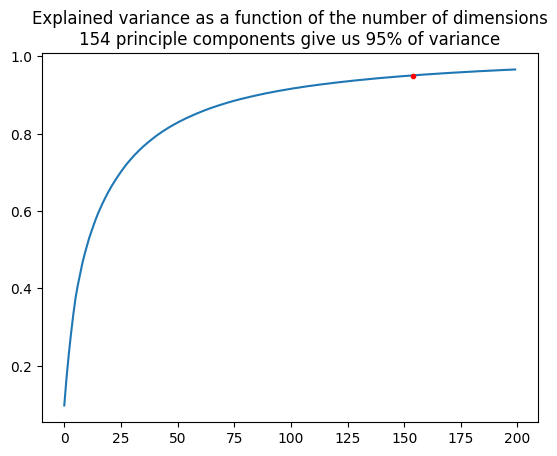

In [ ]:
"""Incremental PCA"""

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, IncrementalPCA
from tqdm import tqdm


# get the data
bunch = fetch_openml('mnist_784', as_frame=False)
X, y = bunch.data, bunch.target

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                          stratify=y, random_state=42)
# define pca
pca = PCA(svd_solver='randomized')       # not this one
pca = IncrementalPCA(n_components=200)   # we need incremental PCA

# simualte online learning
for X_batch in tqdm(np.array_split(X_train, 100)):  # 100 = n_batches
    pca.partial_fit(X_batch)


# or with a memory map
# write the data to a binary file
filename = "x_train.mmap"
mm = np.memmap(filename, dtype=X.dtype, mode='write', shape=X_train.shape)
mm[:] = X_train
mm.flush()

# make a memory-map to read the binary file
mm = np.memmap(filename, dtype=X.dtype, mode='readonly').reshape(*X_train.shape)

# instantiate an Incremental PCA
n_batches = 100
batch_size = mm.shape[0] // n_batches
pca = IncrementalPCA(n_components=200, batch_size=batch_size)

# do PCA incrementally
pca.fit(mm)

# transform the test set, and then restore it back
X_reduced = pca.transform(X_test)
X_restored = pca.inverse_transform(X_reduced)
print("shape of X_reduced:", X_reduced.shape, "\nshape of X_restored", X_restored.shape)

# vizualize the cumulative variance
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1   # d << n

plt.plot(*zip(*enumerate(cumsum)))
plt.plot(d, 0.95, 'r.')
plt.title("Explained variance as a function of the number of dimensions\n"
          f"{d} principle components give us 95% of variance")



In [ ]:
"""Custom Class for partial_fit"""

import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.decomposition import IncrementalPCA
from sklearn.linear_model import SGDClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from tqdm import tqdm


class IncrementalPipeline(BaseEstimator, ClassifierMixin):
    def __init__(self, transformer, classifier):
        self.transformer = transformer
        self.classifier = classifier

    def partial_fit(self, X, y, classes=None):
        if not hasattr(self, 'classes_'):
            self.classes_ = classes

        self.transformer.partial_fit(X)
        X_transformed = self.transformer.transform(X)
        self.classifier.partial_fit(X_transformed, y, classes=self.classes_)
        return self

    def predict(self, X):
        X_transformed = self.transformer.transform(X)
        return self.classifier.predict(X_transformed)

    def predict_proba(self, X):
        X_transformed = self.transformer.transform(X)
        return self.classifier.predict_proba(X_transformed)


# get the data
bunch = fetch_openml('mnist_784', as_frame=False)
X, y = bunch.data, bunch.target
y = [int(c) for c in y]
classes = sorted(set(y))

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                          stratify=y, random_state=42)
# instantiate incremental pipeline
pca = IncrementalPCA(n_components=154)  # 154 : 95%
sgd = SGDClassifier(loss='hinge', penalty='l2', alpha=0.0001)
pipe = IncrementalPipeline(transformer=pca, classifier=sgd)

# simualte online learning (100 batches)
n_batches = 100
for X_batch, y_batch in tqdm(zip(np.array_split(X_train, n_batches),
                                 np.array_split(y_train, n_batches))):
    pipe.partial_fit(X_batch, y_batch, classes=classes)

# asses
acc_train = pipe.score(X_train, y_train)
acc_test = pipe.score(X_test, y_test)
print("train / test accuracy:", acc_train, acc_test)

In [ ]:
# TODO: PANEL REGRESSION
# https://medium.com/pew-research-center-decoded/using-fixed-and-random-effects-models-for-panel-data-in-python-a795865736ab
# https://towardsdatascience.com/a-guide-to-panel-data-regression-theoretics-and-implementation-with-python-4c84c5055cf8